## Conversion Rate Challenge

Le projet Convertion Rate Challenge concerne le site `https://www.datascienceweekly.org/` qui est un blog type news letter de data science qui permet, après inscription sur leur site, de recevoir des news letter chaque semaine.

Les data scientists qui ont créé la newsletter souhaitent mieux comprendre le comportement des utilisateurs visitant leur site web. Ils aimeraient savoir s'il est possible de construire un modèle qui prédit si un utilisateur donné s'abonnera à la newsletter, en utilisant seulement quelques informations sur l'utilisateur. Ils aimeraient analyser les paramètres du modèle pour mettre en évidence des fonctionnalités importantes pour expliquer le comportement des utilisateurs, et peut-être découvrir un nouveau levier d'action pour améliorer le taux de conversion de la newsletter.

Ils ont conçu un concours visant à construire un modèle permettant de prédire les conversions (c'est-à-dire quand un utilisateur s'abonnera à la newsletter). Pour ce faire, ils ont ouvert un ensemble de données contenant des données sur le trafic sur leur site Web. Pour évaluer le classement des différentes équipes en compétition, ils ont décidé d'utiliser le f1-score.

**Objectif** : prédire le taux de conversion à la news letter grace à des paramètres concernant le traffic sur leur site web en utilisant le f1 score comme métrique d'accuracy

In [18]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" 
from IPython.display import display

# METHODOLOGIE

## 1. Exploratory Data Analysis

### Objectif :

* Comprendre du mieux possible nos données : 
* Développer une premiere stratégie de modélisation


#### Analyse de Forme :

* variable target : **`converted`** : est-ce qu'une personne visitant le site s'abonne à la newsletter
* lignes et colonnes : 
    * lignes : 284580
    * colonnes : 6
* types de variables : 
    * qualitatives : 4 variables ==> **`country`**(string), **`new_user`**(binaire), **`source`**(string) et **`converted`**(binaire)
    * quantitatives : 2 variables ==> **`age`**(discrete) et **`total_pages_visited`**(discrete)
* Analyse des valeurs manquantes :
    * Aucune valeur manquante
    
#### Analyse de Fond :

* Visualisation de la target :
    * 96.7% de negatifs (non-abonnés) ==> (9180 / 284580) 
    * 3.3% de positifs (personnes qui se sont abonnés) ==> (275400 / 284580)
* Signification des variables :
    * variables numeriques discrètes : **`age`**(discrete), **`total_pages_visited`**
    * variable qualitative : 
        * binaire (0, 1) : **`new_user`**, **`converted`**(target)
        * nominale : **`country`**, **`source`**
* Relation Variables / Target :
    * target / country : 
    * target / age :   
    * target / new_user :  
    * target / source : 
    * target / total_pages_visited : 

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.shape

(284580, 6)

In [3]:
display(df.head())
display(df.describe(include="all"))
display(df.isna().sum() / df.shape[0])

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [29]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [30]:
df['new_user'].value_counts() / df.shape[0]

1    0.685452
0    0.314548
Name: new_user, dtype: float64

In [31]:
df['converted'].value_counts()  / df.shape[0]

0    0.967742
1    0.032258
Name: converted, dtype: float64

## EDA

### Types de variables

In [32]:
categ_str_features = ['country', 'source']
categ_int_features = ['new_user']
numeric_features = ['age', 'total_pages_visited']
target = 'converted'

### Analyse univariée des variables 

In [33]:
len(df['converted']), len(df['country'])

(284580, 284580)

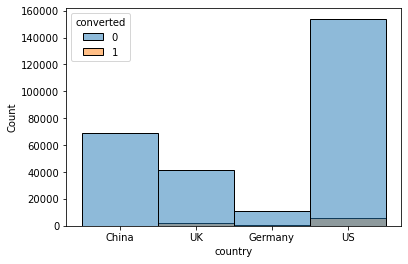

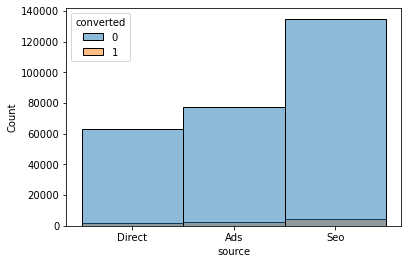

In [34]:
for col in categ_str_features:
    plt.figure()
    sns.histplot(data = df, x=col, hue=target)

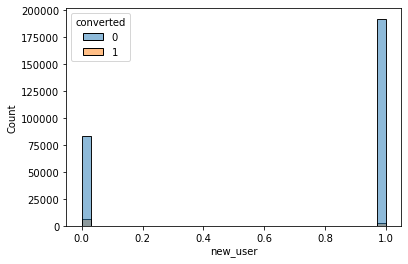

In [35]:
for col in categ_int_features:
    plt.figure()
    sns.histplot(data = df, x=col, hue=target)

<Figure size 432x288 with 0 Axes>

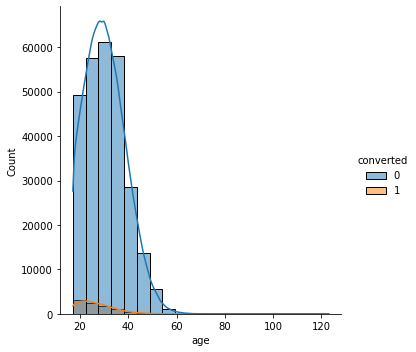

<Figure size 432x288 with 0 Axes>

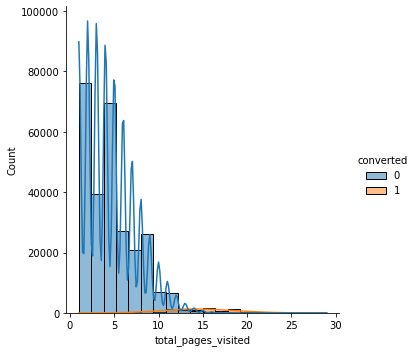

In [36]:
for col in numeric_features:
    plt.figure()
    sns.displot(data = df, x=col, hue=target, bins=20, kde=True)

### Analyse en fonction de 'converted'

on va créer 2 groupes : `converted == 'yes'` et `converted == 'no'`

In [37]:
converted = df[df['converted'] == 1]
non_converted = df[df['converted'] == 0]

In [38]:
print(len(converted))
print(len(non_converted))

9180
275400


### Relation Target / Numerical

#### (Target / Age) & (Target / Total_pages_visited)

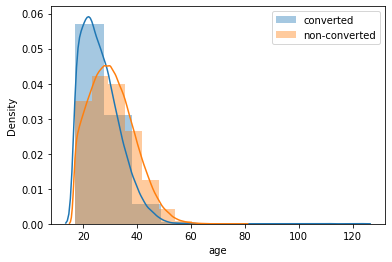

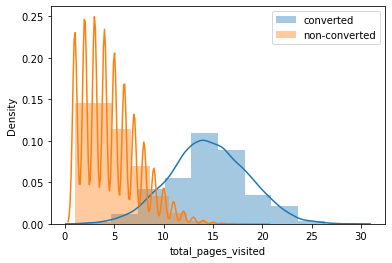

In [39]:
for col in numeric_features:
    plt.figure()
    sns.distplot(converted[col], label='converted', bins=10)
    sns.distplot(non_converted[col], label='non-converted',bins=10)
    plt.legend()

### Relation Target / Categorical

#### Target / Country

country,China,Germany,UK,US
converted,,,,
0,0.998712,0.937569,0.947503,0.962092
1,0.001288,0.062431,0.052497,0.037908


<AxesSubplot:xlabel='country', ylabel='converted'>

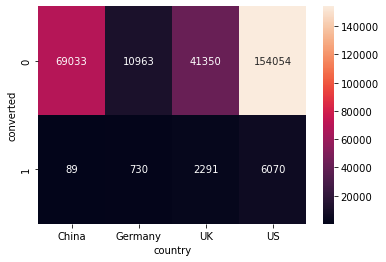

In [40]:
display(pd.crosstab(df['converted'], df['country'], normalize='columns'))
plt.figure()
sns.heatmap(pd.crosstab(df['converted'], df['country']), annot=True, fmt='d')

#### Target / Source

source,Ads,Direct,Seo
converted,,,
0,0.965199,0.972186,0.967127
1,0.034801,0.027814,0.032873


<AxesSubplot:xlabel='source', ylabel='converted'>

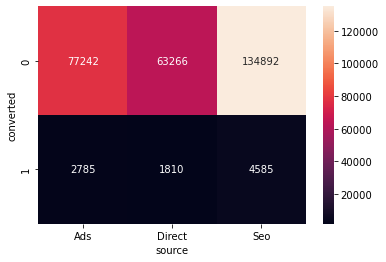

In [41]:
display(pd.crosstab(df['converted'], df['source'], normalize='columns'))
plt.figure()
sns.heatmap(pd.crosstab(df['converted'], df['source']), annot=True, fmt='d')

#### Target / New_user

new_user,0,1
converted,,
0,0.928067,0.985948
1,0.071933,0.014052


<AxesSubplot:xlabel='new_user', ylabel='converted'>

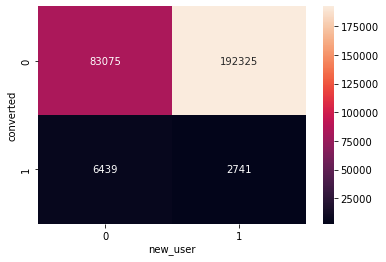

In [42]:
display(pd.crosstab(df['converted'], df['new_user'], normalize='columns'))
plt.figure()
sns.heatmap(pd.crosstab(df['converted'], df['new_user']), annot=True, fmt='d')

### Preprocessing

In [3]:
X = df.iloc[:, :-1]
y = df.loc[:, 'converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

In [16]:
numeric_features = ['age', 'total_pages_visited']
categ_features = ['country', 'source', 'new_user']

num_transf = make_pipeline(
    (SimpleImputer(strategy='mean')),
    (StandardScaler())
)

categ_transf = OneHotEncoder(drop='first')

preprocessor = make_column_transformer(
    (num_transf, numeric_features),
    (categ_transf, categ_features)
)

In [ ]:
regressors = make_pipeline(
    (LogisticRegression()),
    (DecisionTreeClassifier()),
    (RandomForestClassifier()),
    (SVC())
)

regressors

In [46]:
pip1 = make_pipeline(
    (preprocessor),
    (regressors)
)

pip1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'total_pages_visited']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source',
                                                   'new_user'])])),
                ('pipeline',
                 Pipeline(steps=[('logisticregression', LogisticRegression()),
                                 ('decisiontreeclassifier',
                                  DecisionTreeClassifier()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier()),
                                 ('svc', SVC())]))])

In [49]:
X_train = pip1[0].fit_transform(X_train)
X_test = pip1[0].transform(X_test)

In [47]:
pip1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'total_pages_visited']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source',
                                                   'new_user'])])),
                ('pipeline',
                 Pipeline(steps=[('logisticregression', LogisticRegression()),
                                 ('decisiontreeclassifier',
                                  DecisionTreeClassifier()),
                                 ('randomforestclassifier',
                                  RandomForestClassifier()),
                                 ('svc', SVC())]))])

### LogisticRegression

In [24]:
scores_lr = cross_val_score(pip1[1][0], X_train, y_train, cv=5)
print(scores_lr.mean())
print(scores_lr.std())

0.9863307301581349
0.0004115222348482242


In [111]:
params = {
    'C' : np.logspace(-3,3,7),
    'penalty' : ['l1','l2']
}

gridsearch_lr = GridSearchCV(pip1[1][0], param_grid = params, cv=5)
gridsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [28]:
print("Best hyperparameters : ", gridsearch_lr.best_params_)
print("Best R2 score : ", gridsearch_lr.best_score_)

Best hyperparameters :  {'C': 10.0, 'penalty': 'l2'}
Best R2 score :  0.9863463476086849


In [30]:
y_train_pred_lr = gridsearch_lr.predict(X_train)
y_test_pred_lr = gridsearch_lr.predict(X_test)

In [31]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.7649788178333669
f1-score sur le test set :  0.7568513119533526


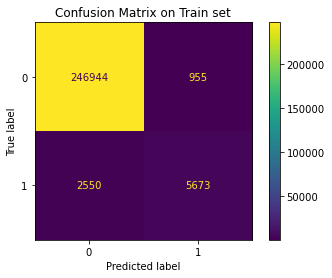

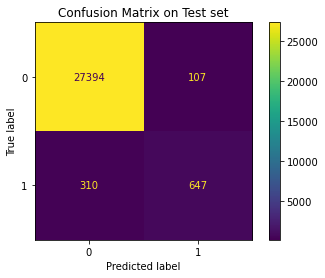

In [118]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_test, y_test, ax=ax) 
plt.show()

In [40]:
print(classification_report(y_train, y_train_pred_lr))
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.86      0.69      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.92      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.86      0.68      0.76       957

    accuracy                           0.99     28458
   macro avg       0.92      0.84      0.87     28458
weighted avg       0.98      0.99      0.98     28458



### Decision Tree

In [32]:
scores_dt = cross_val_score(pip1[1][1], X_train, y_train, cv=10)
print(scores_dt.mean())
print(scores_dt.std())

0.9843473046369215
0.000523047592766258


In [33]:
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}

gridsearch_dt = GridSearchCV(pip1[1][1], param_grid = params, cv=5)
gridsearch_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8]})

In [34]:
print("Best hyperparameters : ", gridsearch_dt.best_params_)
print("Best R2 score : ", gridsearch_dt.best_score_)

Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best R2 score :  0.9854092952402208


In [35]:
y_train_pred_dt = gridsearch_dt.predict(X_train)
y_test_pred_dt = gridsearch_dt.predict(X_test)

In [37]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_dt))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_dt))

f1-score sur le train set :  0.7625342145670606
f1-score sur le test set :  0.7579068430132261


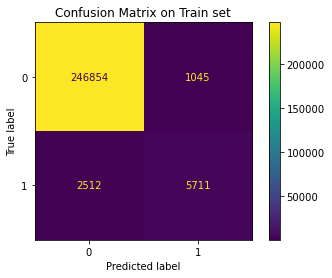

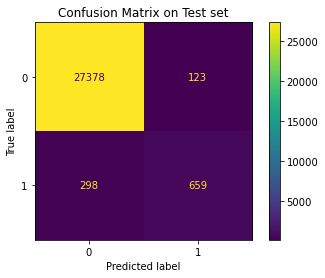

In [38]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_dt, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_dt, X_test, y_test, ax=ax) 
plt.show()

In [39]:
print(classification_report(y_train, y_train_pred_dt))
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.85      0.69      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.92      0.85      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.84      0.69      0.76       957

    accuracy                           0.99     28458
   macro avg       0.92      0.84      0.88     28458
weighted avg       0.98      0.99      0.98     28458



### RandomForest

In [79]:
scores_rf = cross_val_score(pip1[1][2], X_train, y_train, cv=10)
print(scores_rf.mean())
print(scores_rf.std())

0.9845893762256972
0.00044033931879891504


In [89]:
params = {
    'max_depth': [7,8,9],
    'min_samples_leaf': [4,5,6],
    'min_samples_split': [3,4,5],
    'n_estimators': [55,60,65,70]
}

gridsearch = GridSearchCV(pip1[1][2], param_grid = params, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 8, 9], 'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [55, 60, 65, 70]})

In [166]:
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}

gridsearch = GridSearchCV(pip1[1][2], param_grid = params, cv=5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [90]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 55}
Best R2 score :  0.9860808507206732


In [140]:
with open('random_forest_model', 'wb') as f:
    pickle.dump(gridsearch, f)

In [106]:
y_train_pred_rf = gridsearch.predict(X_train)
y_test_pred_rf = gridsearch.predict(X_test)

In [107]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_rf))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_rf))

f1-score sur le train set :  0.7683945920239147
f1-score sur le test set :  0.7591836734693876


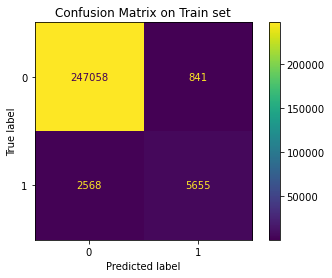

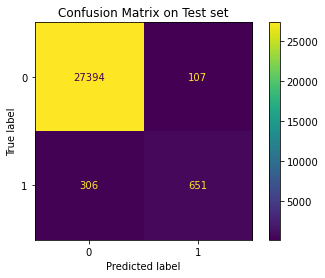

In [93]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) 
plt.show()

In [172]:
print(classification_report(y_train, y_train_pred_rf))
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.87      0.68      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.86      0.67      0.75       957

    accuracy                           0.99     28458
   macro avg       0.92      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



### SVM

In [9]:
scores_svm = cross_val_score(pip1[1][3], X_train, y_train, cv=5)
print(scores_svm.mean())
print(scores_svm.std())

0.9859559086772023
0.00042343116297213426


In [11]:
param_grid={'C': [1, 5, 10, 50],
            'gamma': [0.0001, 0.0005, 0.001, 0.005]}

gridsearch_svm = GridSearchCV(pip1[1][3], param_grid = param_grid, cv=5)
gridsearch_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 5, 10, 50],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005]})

In [13]:
print("Best hyperparameters : ", gridsearch_svm.best_params_)
print("Best R2 score : ", gridsearch_svm.best_score_)

Best hyperparameters :  {'C': 50, 'gamma': 0.0005}
Best R2 score :  0.9861628418596793


In [12]:
y_train_pred_svm = gridsearch_svm.predict(X_train)
y_test_pred_svm = gridsearch_svm.predict(X_test)

In [14]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_svm))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_svm))

f1-score sur le train set :  0.7557546519641626
f1-score sur le test set :  0.7544483985765125


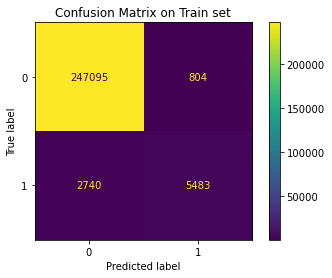

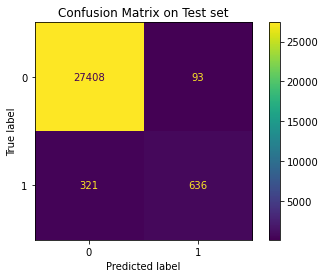

In [15]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_svm, X_train, y_train, ax=ax)
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_svm, X_test, y_test, ax=ax) 
plt.show()

In [16]:
print(classification_report(y_train, y_train_pred_svm))
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.87      0.67      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.83      0.87    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.87      0.66      0.75       957

    accuracy                           0.99     28458
   macro avg       0.93      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



In [17]:
import pickle

In [ ]:
with open('random_forest_model', 'wb') as f:
    pickle.dump(gridsearch, f)

In [19]:
with open('svc_model', 'rb') as f:
    mp = pickle.load(f)

In [20]:
mp.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
mp.score(X_test, y_test)

0.9854522454142948

In [24]:
data_without_labels = pd.read_csv('conversion_data_test.csv')

In [25]:
data_without_labels.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [60]:
data_without_labels.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
dtype: int64

In [50]:
X = pip1[0].transform(data_without_labels)

In [51]:
data = {
    'converted': mp.predict(X)
}

In [54]:
y_predictions = pd.DataFrame(columns=['converted'],data=data)
y_predictions.to_csv('conversion_data_test_predictions_test1_david_tg.csv', index=False)

In [53]:
y_predictions

,converted
0,1
1,0
2,0
3,0
4,0
...,...
31615,0
31616,0
31617,0
31618,1


### Test with Lasso and Ridge

### RidgeClassifier

In [58]:
from sklearn.linear_model import RidgeClassifier, Lasso

In [66]:
ridge1 = RidgeClassifier()
ridge1.fit(X_train, y_train)

print("R2 score sur le training set : ", ridge1.score(X_train, y_train))
print("R2 score sur le test set : ", ridge1.score(X_test, y_test))

R2 score sur le training set :  0.9696082335761863
R2 score sur le test set :  0.9682690280413241


In [67]:
param_grid={'alpha':  [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}

gridsearch_ridge = GridSearchCV(ridge1, param_grid=param_grid, cv=5)
gridsearch_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]})

In [68]:
print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R2 score : ", gridsearch_ridge.best_score_)

Best hyperparameters :  {'alpha': 0.01}
Best R2 score :  0.9696082345185468


In [69]:
print("R2 score sur le training set : ", gridsearch_ridge.score(X_train, y_train))
print("R2 score sur le test set : ", gridsearch_ridge.score(X_test, y_test))

R2 score sur le training set :  0.9696082335761863
R2 score sur le test set :  0.9682690280413241


In [70]:
y_train_pred_ridge = gridsearch_ridge.predict(X_train)
y_test_pred_ridge = gridsearch_ridge.predict(X_test)

In [71]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_ridge))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_ridge))

f1-score sur le train set :  0.1013622719926114
f1-score sur le test set :  0.10682492581602374


### Lasso

In [72]:
lasso = Lasso()

params = {
    'alpha': [1, 2, 3, 5, 10, 20, 30]
}
best_lasso = GridSearchCV(lasso, param_grid = params, cv = 5)
best_lasso.fit(X_train, y_train)

print("Best hyperparameters : ", best_lasso.best_params_)
print("Best R2 score : ", best_lasso.best_score_)

Best hyperparameters :  {'alpha': 1}
Best R2 score :  -1.4837207351625636e-05


### RF

In [ ]:
rfc = RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=4, n_estimators=60)

In [83]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=60)

In [84]:
y_train_pred_randomf = rfc.predict(X_train)
y_test_pred_randomf = rfc.predict(X_test)

In [85]:
print("R2 score sur le training set : ", rfc.score(X_train, y_train))
print("R2 score sur le test set : ", rfc.score(X_test, y_test))

R2 score sur le training set :  0.9863892988497669
R2 score sur le test set :  0.9849954318645021


In [87]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_randomf))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_randomf))

f1-score sur le train set :  0.7609381429159238
f1-score sur le test set :  0.7468879668049793


In [94]:
param_grid={'C': [40,50,60],
            'gamma': [0.0005]}

gridsearch_svm = GridSearchCV(pip1[1][3], param_grid = param_grid, cv=5)
gridsearch_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [40, 50, 60], 'gamma': [0.0005]})

In [95]:
print("Best hyperparameters : ", gridsearch_svm.best_params_)
print("Best R2 score : ", gridsearch_svm.best_score_)

Best hyperparameters :  {'C': 50, 'gamma': 0.0005}
Best R2 score :  0.9861628418596793


### Optimize SVC

In [122]:
svc = SVC(C=48, gamma=0.0005, probability=True)

In [123]:
svc.fit(X_train,y_train)

SVC(C=48, gamma=0.0005, probability=True)

In [139]:
with open('svc_proba_model', 'wb') as f:
    pickle.dump(svc, f)

In [100]:
y_train_pred_svc1 = svc.predict(X_train)
y_test_pred_svc1 = svc.predict(X_test)

In [102]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_randomf))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_randomf))

f1-score sur le train set :  0.7609381429159238
f1-score sur le test set :  0.7468879668049793


In [103]:
print(classification_report(y_train, y_train_pred_svc1))
print(classification_report(y_test, y_test_pred_svc1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.87      0.67      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.83      0.87    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.87      0.66      0.75       957

    accuracy                           0.99     28458
   macro avg       0.93      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



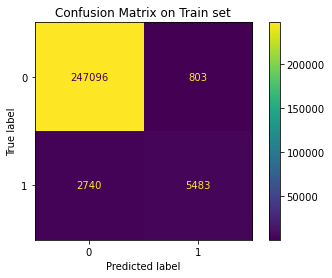

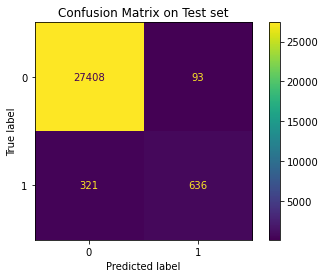

In [105]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(svc, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, ax=ax) 
plt.show()

In [124]:
voting = VotingClassifier(estimators=[("svc", svc), ("tree", gridsearch), ("svm", gridsearch_lr)], voting='soft') 
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(C=48, gamma=0.0005, probability=True)),
                             ('tree',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(),
                                           param_grid={'max_depth': [7, 8, 9],
                                                       'min_samples_leaf': [4,
                                                                            5,
                                                                            6],
                                                       'min_samples_split': [3,
                                                                             4,
                                                                             5],
                                                       'n_estimators': [55, 60,
                                                                        65,
                                                                        70]})),
                             ('svm',
                              GridSearchCV(cv=5, estimator=LogisticRegression(),
                                           param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                       'penalty': ['l1',
                                                                   'l2']}))],
                 voting='soft')

In [121]:
from sklearn.calibration import CalibratedClassifierCV
model = CalibratedClassifierCV(svc)
model.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=48, gamma=0.0005))

In [127]:
voting_pred_train = voting.predict(X_train)
voting_pred_test = voting.predict(X_test)

In [126]:
print("Accuracy on training set : ", voting.score(X_train, y_train))
print("Accuracy on test set : ", voting.score(X_test, y_test))

Accuracy on training set :  0.9863932032390814
Accuracy on test set :  0.9852765478951437


In [128]:
print("f1-score sur le train set : ", f1_score(y_train, voting_pred_train))
print("f1-score sur le test set : ", f1_score(y_test, voting_pred_test))

f1-score sur le train set :  0.7637127940877348
f1-score sur le test set :  0.7545401288810779


In [129]:
print(classification_report(y_train, voting_pred_train))
print(classification_report(y_test, voting_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247899
           1       0.86      0.68      0.76      8223

    accuracy                           0.99    256122
   macro avg       0.93      0.84      0.88    256122
weighted avg       0.99      0.99      0.99    256122

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27501
           1       0.86      0.67      0.75       957

    accuracy                           0.99     28458
   macro avg       0.92      0.83      0.87     28458
weighted avg       0.98      0.99      0.98     28458



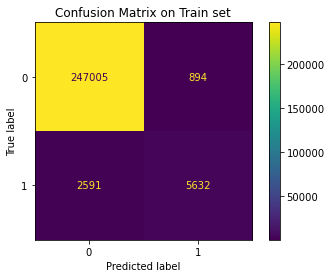

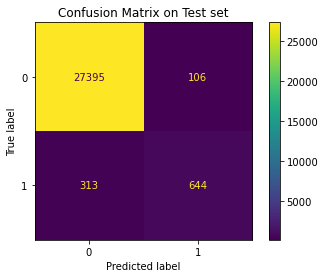

In [130]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(voting, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(voting, X_test, y_test, ax=ax) 
plt.show()

In [138]:
with open('stacking_model', 'wb') as f:
    pickle.dump(stacking, f)

In [133]:
stacking = StackingClassifier(estimators = [("svc", svc), ("tree", gridsearch), ("svm", gridsearch_lr)], cv=3)

preds = stacking.fit_transform(X_train, y_train)

In [134]:
print("Accuracy on training set : ", stacking.score(X_train, y_train))
print("Accuracy on test set : ", stacking.score(X_test, y_test))

Accuracy on training set :  0.9858661106816283
Accuracy on test set :  0.9852765478951437


In [135]:
print("f1-score sur le train set : ", f1_score(y_train, voting_pred_train))
print("f1-score sur le test set : ", f1_score(y_test, voting_pred_test))

f1-score sur le train set :  0.7637127940877348
f1-score sur le test set :  0.7545401288810779


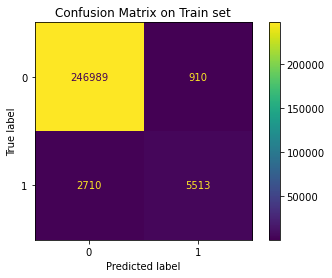

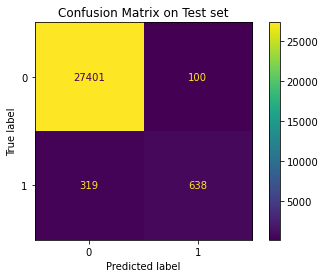

In [144]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(stacking, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(stacking, X_test, y_test, ax=ax) 
plt.show()

In [ ]:
xgboost = XGBClassifier()

params = {
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3], 
    'n_estimators': [2, 4, 6, 8,] 
}

gridsearch = GridSearchCV(xgboost, param_grid = params, cv=3) 
gridsearch.fit(X_train, Y_train)